# Introduction and project overview

## Overview of Amoebiasis

Amoebiasis is a parasitic infection caused by the amoeba _Entamoeba histolytica_. It primarily affects the intestines and can cause symptoms such as abdominal pain, diarrhea, and bloody stools. However, many people with amoebiasis may not show any symptoms. The infection is typically spread through contaminated food or water, and it's more common in areas with poor sanitation.

The following temporal variables can help in accurately diagnosing the disease's status in the event an individual has it.

**Date of Onset**: This is the date when the person first started experiencing symptoms. It's crucial for understanding the incubation period and the timeline of the disease progression.

**Date of Notification**: This is the date when the case was reported to health authorities. It's important for tracking the spread of the disease and initiating public health responses.

**Date of Confirmation**: This is the date when the diagnosis was confirmed, usually through laboratory tests. It ensures the accuracy of the case and helps in monitoring the effectiveness of diagnostic methods.


For predicting amoebiasis, the _Date of Onset_ might be the most relevant, as it provides information on when the infection started, which is critical for understanding the disease's timeline and potential sources of infection.

However, using the Date of Confirmation could also be beneficial, as it ensures that the cases included in your model are accurately diagnosed, reducing the risk of including false positives.

Since the focus is on early detection and prevention, I selected the Date of Onset.


The incubation periodis typically 2-4 weeks. Transmission can also occur through exposure to fecal matter during sexual contact. Most infections are asymptomatic. Only about 10% to 20% of people who are infected with E. histolytica become sick from the infection.

In Taiwan, most of the reported cases come from Taipei or in Southern region [[1]](https://www.sciencedirect.com/science/article/abs/pii/S0033350613002977). Furthermore, a significaiant potion of the reported cases are from HIV-infected individuals. E. histolytica is highly prevalent among male homosexuals in Taiwan. [[2]](https://www.cdc.gov.tw/En/Category/ListContent/bg0g_VU_Ysrgkes_KRUDgQ?uaid=tXaqigJTbNFHK-phT2Pgxw) Moreover, importing foreign workers from Southeast Asia has led to an increase in imported cases in Taiwan. [[2]](https://www.cdc.gov.tw/En/Category/ListContent/bg0g_VU_Ysrgkes_KRUDgQ?uaid=tXaqigJTbNFHK-phT2Pgxw)


In this project, I constructed an ML model to predict amoebiasis cases in Southern Taiwan 1 week after the last known case using lagged values of imported cases and total cases as features. I will also use Transfer Entropy (TE) to determine the maximum lags of the former. An XGB model was utilized in this project; its hyperparameters were optimized using Bayesian optimization.


# 1. Data processing and exploratory data analysis (EDA)

In [2]:
!pip install pyinform scikit-optimize

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


Necessary libraries were installed prior to EDA. The data was sourced from [[3]](https://nidss.cdc.gov.tw/). The temporal resolution was weekly, and the period ranged from week 1 of 1995 to week 1 of 2025. There were two datasets used: imported and imported + indigenous.

`pandas` was used to analyze the datasets. The other libraries that were utlized included `sklearn`, `xgboost`, `pyinform` (for TE), and `scikit-optimize`.

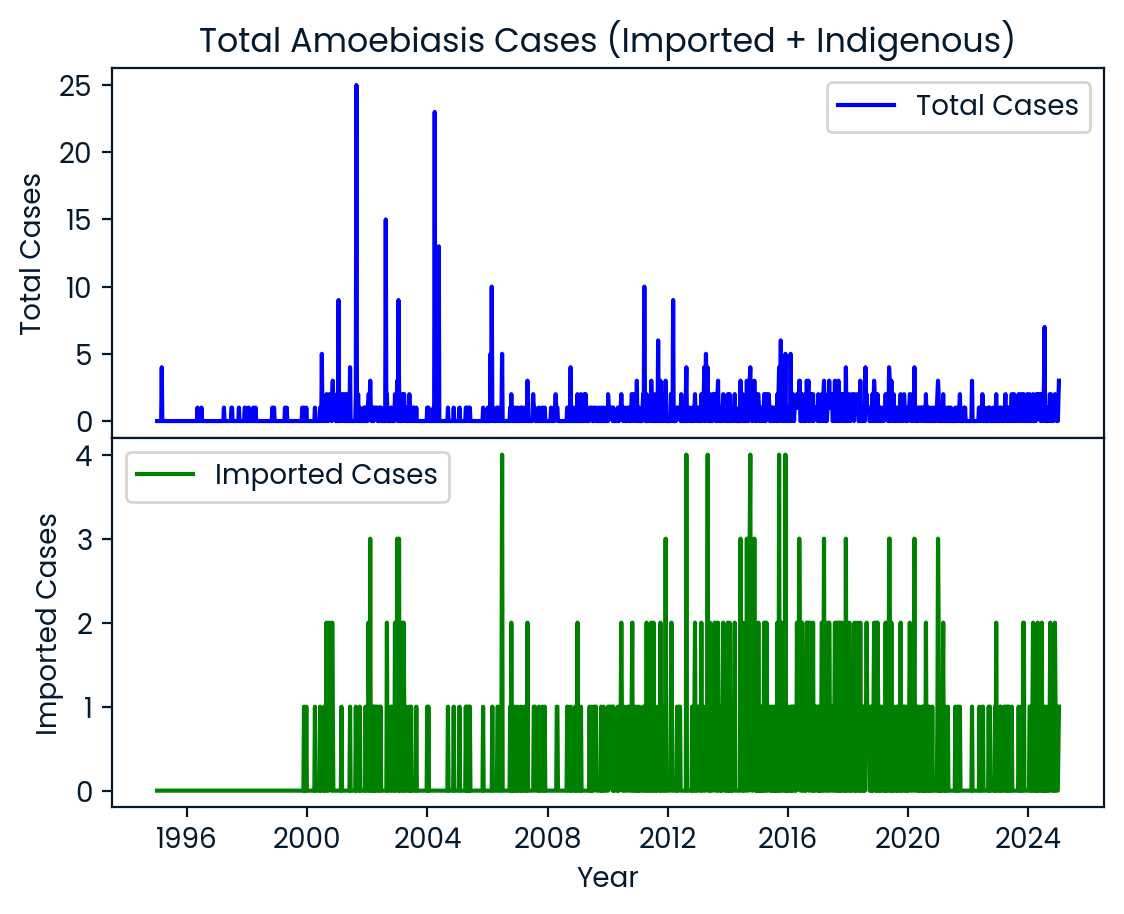

In [55]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pyinform
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb

# 1. Data Processing and Exploratory Data Analysis (EDA)

# Load the dataset
data = pd.read_csv('amoebiasis-southern-importedANDindigenous-199501-202501-weekly-amoebiasis.csv')

data_imported = pd.read_csv('amoebiasis-southern-imported-199501-202501-weekly-amoebiasis.csv')


# Convert YYYY-WW to datetime
def convert_to_datetime(year_week):
    year = int(year_week[:4])
    week = int(year_week[4:])
    return pd.to_datetime(f'{year}-{week}-1', format='%Y-%W-%w')

# Apply the function to the 'week_date' column
data['Onset Year-Week'] = data['Onset Year-Week'].astype(str).apply(convert_to_datetime)
data_imported['Onset Year-Week'] = data_imported['Onset Year-Week'].astype(str).apply(convert_to_datetime)


# Handle missing values by forward filling
data = data.fillna(method='ffill')
data_imported = data_imported.fillna(method='ffill')


# Create subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})

# Plot total cases on the top subplot
ax1.plot(data['Onset Year-Week'], data["Number of Confirmed Cases"], label='Total Cases', color='blue')
ax1.set_ylabel('Total Cases')
ax1.set_title('Total Amoebiasis Cases (Imported + Indigenous)')
ax1.legend()

# Plot imported cases on the bottom subplot
ax2.plot(data_imported['Onset Year-Week'], data_imported["Number of Confirmed Cases"], label='Imported Cases', color='green')
ax2.set_xlabel('Year')
ax2.set_ylabel('Imported Cases')
ax2.legend()

plt.show()

The plot shows that imported cases, defined as instances where an individual contracts an infection outside of a specific geographic area and then brings it into that area [[4]](https://europepmc.org/article/PMC/7910701), represent a significant proportion of the total cases. This observation prompted me to use lagged imported cases as a model feature.

# 2. Feature engineering


**Transfer entropy**

_TE_ is a measure of the directed (time-asymmetric) transfer of information between two random processes. It quantifies how much the uncertainty in one process (the target) is reduced by knowing the past values of another process (the source), given the past values of the target. [[5]](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0099462)


$TE_{x\rightarrow y}=H\left(Y_{t}| Y_{t-1 :t-L},X_{t-1 :t-L}\right)$


where _H_ is the Shannon entropy, and _L_ is the lag. This variable is nonnegative: $TE\geq 0$

In this project, _TE_ between lagged imported case and current total case is calculated, and the optimal lag is determined.

Note that _TE(t-1, t)_ measures the amount of information that past values (at time _t-1_ provide about future values (at time _t_).


In [60]:

# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42) # shuffle=False, 

train_imported, test_imported = train_test_split(data_imported, test_size=0.2, shuffle=False, random_state=42)

# 2. Feature Engineering

# Function to calculate transfer entropy using pyinform
def calculate_transfer_entropy(lagged_imported, current_cases):
    te = pyinform.transferentropy.transfer_entropy(lagged_imported, current_cases, k=1)
    return te

# Find the optimal lag
max_lag = 18  # Example: up to 18 weeks
optimal_lag, optimal_lag_self = 0,0
max_te = 0
for lag in range(1, max_lag + 1):
    lagged_imported = train_imported["Number of Confirmed Cases"].shift(lag).dropna().astype(int).tolist()
    current_cases = train_data["Number of Confirmed Cases"][lag:].astype(int).tolist()
    te = calculate_transfer_entropy(lagged_imported, current_cases)
    if te > max_te:
        max_te = te
        optimal_lag = lag
        

for lag in range(1, max_lag + 1):
    lagged_self = train_data["Number of Confirmed Cases"].shift(lag).dropna().astype(int).tolist()
    current_cases = train_data["Number of Confirmed Cases"][lag:].astype(int).tolist()
    te = calculate_transfer_entropy(lagged_self, current_cases)
    if te > max_te:
        max_te = te
        optimal_lag_self = lag

# # Create lagged features
# train_data['lagged_imported'] = train_imported["Number of Confirmed Cases"].shift(optimal_lag)
# train_data = train_data.dropna()



In [61]:
print(optimal_lag, optimal_lag_self)

(3, 2)

# 3. Hyperparameter Optimization using Bayesian Optimization

Best parameters: OrderedDict([('colsample_bytree', 0.5), ('gamma', 0.5), ('learning_rate', 0.04255585505740016), ('max_depth', 3), ('min_child_weight', 10), ('n_estimators', 50), ('subsample', 0.5)])
Mean Squared Error: 0.6219846224907576
R-squared: -0.00709945351482788


<Figure size 640x480 with 0 Axes>

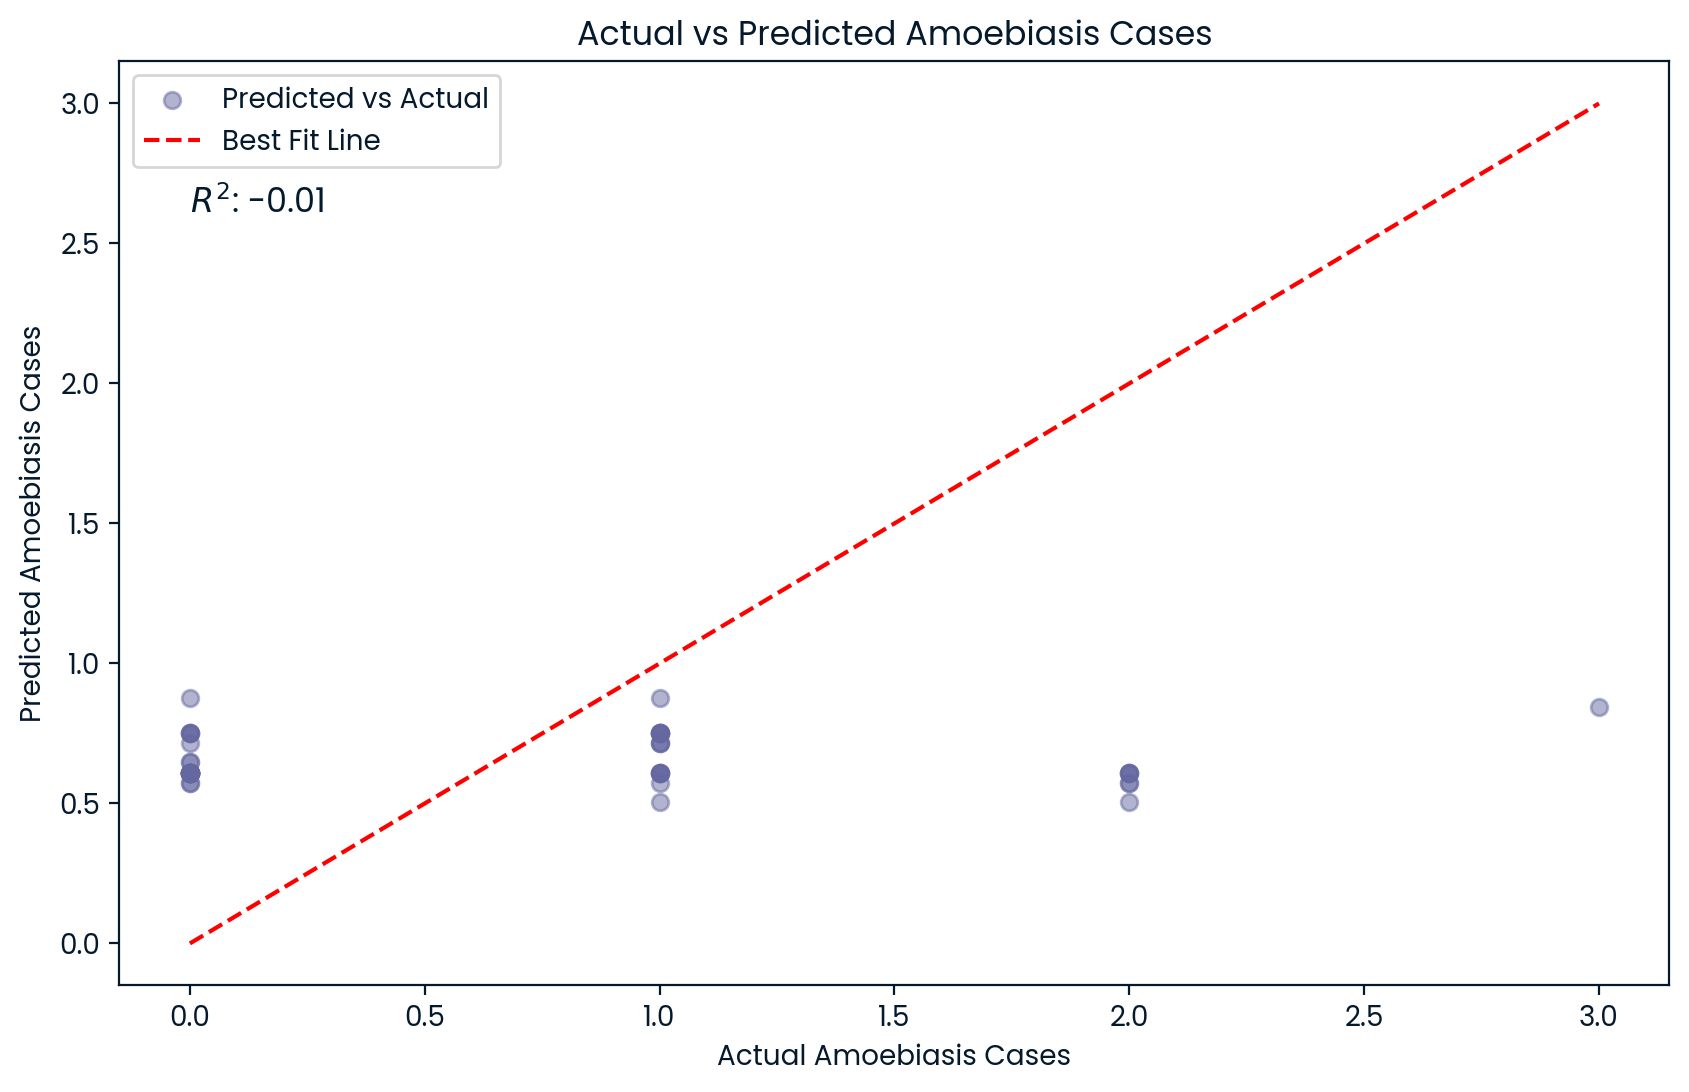

In [74]:
# Create lagged features
train_data['lagged_imported'] = train_imported["Number of Confirmed Cases"].shift(optimal_lag)
train_data['lagged_self'] = train_data["Number of Confirmed Cases"].shift(optimal_lag_self)
train_data = train_data.dropna()

# Prepare the test set with lagged features
test_data['lagged_imported'] = test_imported["Number of Confirmed Cases"].shift(optimal_lag)
test_data['lagged_self'] = test_imported["Number of Confirmed Cases"].shift(optimal_lag_self)
test_data = test_data.dropna()


def func_ln(x,const=2): return np.log(x+const)

log_transformer = FunctionTransformer(func_ln, validate=True)

# Create a pipeline to standardize the data
pipeline = Pipeline([
    ('log_transform', log_transformer),
    ('scaler', StandardScaler()),
])
X_train = train_data[['lagged_imported', 'lagged_self']]
y_train = train_data['Number of Confirmed Cases']

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Transform the training and test data
X_test = test_data[['lagged_imported', 'lagged_self']]
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)    
    

# 3. Hyperparameter Optimization using Bayesian Optimization

# Count zeros and nonzeros
neg_count = (y_train == 0).sum()
pos_count = (y_train != 0).sum()

# Calculate scale_pos_weight
scale_pos_weight = neg_count / pos_count


# Define the parameter space
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, scale_pos_weight = scale_pos_weight) # 
param_space = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.01, 0.3, 'log-uniform'),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0,0.5),
    'subsample': Real(0.5, 1),
    'colsample_bytree': Real(0.5, 1)
}

# Perform Bayesian optimization
opt = BayesSearchCV(model, param_space, n_iter=64, cv=5, n_jobs=-1) #  scoring='neg_mean_squared_error',

opt.fit(X_train_scaled, y_train)

# Best parameters
best_params = opt.best_params_
print(f"Best parameters: {best_params}")


# 4. Model Training and Evaluation

In [ ]:
# 4. Model Training and Evaluation

# Train the model with the best parameters
best_model = opt.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Prepare the test set
y_test = test_data["Number of Confirmed Cases"]

# Predict and evaluate
y_pred = best_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Plot predicted vs actual values
plt.clf()
plt.figure(figsize=(10, 6))
# plt.plot(test_data['Onset Year-Week'], y_test, label='Actual')
# plt.plot(test_data['Onset Year-Week'], y_pred, label='Predicted')
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Best Fit Line')
plt.title('Actual vs Predicted Amoebiasis Cases')
plt.xlabel('Actual Amoebiasis Cases')
plt.ylabel('Predicted Amoebiasis Cases')
plt.legend(loc='best')
# Add R^2 value as text
plt.text(min(y_test), 0.9*max(y_test), f'$R^2$: {r2:.2f}', fontsize=12, verticalalignment='top')

plt.show()

# Discussion

The results are not what we expected. These reveal the limitations of this project. I haven't explored the possibility of using climatological data as features for the ML model. Furthermore, I haven't considered using the autocorrrelation function as basis for the optimal lags. Also note that the cases are full of zeros, in which the model might have put bias to outputs close to zero. Nevertheless, I've laid the groundwork for amoebiasis forecasting. If you have inputs you'd like to share, send them my way at jprmaulion[at]gmail[dot]com. 